# Twitter Setiment Analysis using [BERT model](https://huggingface.co/bert-base-uncased)
Sentiment Analysis using [US Airlines twitter sentiment dataset](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment) from Kaggle (multiclass classification) and [BERT Tokenizer](https://huggingface.co/docs/transformers/v4.21.1/en/model_doc/bert#transformers.BertTokenizer) based on [WordPiece](https://huggingface.co/docs/transformers/tokenizer_summary#wordpiece)<br>


In [ ]:
#Check if GPU is available on notebook
import torch
torch.cuda.is_available()

True

## 1.Download Libraries

In [ ]:
#To clone and upload models
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
!pip install datasets transformers huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 13.7 MB/s 
     |████████████████████████████████| 4.7 MB 36.1 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 212 kB 65.3 MB/s 
     |████████████████████████████████| 115 kB 76.0 MB/s 
     |████████████████████████████████| 141 kB 78.1 MB/s 
     |████████████████████████████████| 596 kB 68.9 MB/s 
     |████████████████████████████████| 127 kB 62.4 MB/s 
     |████████████████████████████████| 6.6 MB 49.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#For model evaluation metrics
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 6.3 MB/s 


In [ ]:
#Imports
import re #for regex removal
#Libraries for loading pretrained models and datasets
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
#Libraries for performance evaluation metrics
import numpy as np
from datasets import load_metric
from evaluate import load
#Libraries for fine-tuning model
from transformers import TrainingArguments, Trainer
#Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

## 2.Load and Preprocess Dataset

In [ ]:
#Add your Hugging Face token
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"

### 2.1.Load dataset

In [ ]:
#Uploade dataset file
dataset = load_dataset("csv", data_files="/content/US Airline Twitter Sentiment Analysis.csv")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'],
        num_rows: 14640
    })
})

### 2.2.Preprocess Dataset
- Remove columns
- Rename column
- One hot encode labels
- train-validation-test split

In [ ]:
#Useful columns ['airline_sentiment', 'text']
#Remove unneccesary columns
dataset = dataset.remove_columns(['tweet_id', 'airline_sentiment_confidence',
                        'negativereason', 'negativereason_confidence', 'airline',
                        'airline_sentiment_gold', 'name', 'negativereason_gold',
                        'retweet_count', 'tweet_coord', 'tweet_created',
                        'tweet_location', 'user_timezone'])

In [ ]:
#Rename column
dataset = dataset.rename_column('airline_sentiment', 'label')

In [ ]:
dataset['train'][13]

{'label': 'positive',
 'text': "@VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn"}

In [ ]:
#Convert airline_sentiment column into integer values
def convert_to_numbers(example):
  label_mapping = {'negative':0,'positive':1,'neutral':2}
  return {'label': label_mapping[example['label']] }

In [ ]:
dataset = dataset.map(convert_to_numbers)

  0%|          | 0/14640 [00:00<?, ?ex/s]

In [ ]:
dataset['train'][13]

{'label': 1,
 'text': "@VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn"}

In [ ]:
#Removing URLS from text column
def remove_url(example):
  text = re.sub('http\S+', '', example['text']).strip()
  return {'text': re.sub('www\S+', '', text).strip()}

In [ ]:
dataset = dataset.map(remove_url)

  0%|          | 0/14640 [00:00<?, ?ex/s]

In [ ]:
print(dataset['train'][13])

{'label': 1, 'text': "@VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel"}


In [ ]:
#Train,Validation,Test split
tweets_dataset_temp = dataset['train'].train_test_split(test_size=0.30, seed = 42)
tweets_dataset = tweets_dataset_temp['train'].train_test_split(test_size=0.10, seed = 42)
tweets_dataset['validation'] = tweets_dataset.pop('test')
tweets_dataset['test'] = tweets_dataset_temp['test']

In [ ]:
tweets_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 9223
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1025
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 4392
    })
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
#Sample text for understanding preprocessing
sample_txt = dataset['train'][13]['text']

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt} \nTokens:{tokens} \nToken ids:{token_ids}')
print(f"no. of tokens: {len(tokens)}")

 Sentence: @VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn 
Tokens:['@', 'virgin', '##ame', '##rica', '@', 'virgin', '##media', 'i', "'", 'm', 'flying', 'your', '#', 'fabulous', '#', 'seductive', 'skies', 'again', '!', 'u', 'take', 'all', 'the', '#', 'stress', 'away', 'from', 'travel', 'http', ':', '/', '/', 't', '.', 'co', '/', 'ahl', '##x', '##hh', '##ki', '##yn'] 
Token ids:[1030, 6261, 14074, 14735, 1030, 6261, 16969, 1045, 1005, 1049, 3909, 2115, 1001, 18783, 1001, 23182, 15717, 2153, 999, 1057, 2202, 2035, 1996, 1001, 6911, 2185, 2013, 3604, 8299, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 18347, 2595, 23644, 3211, 6038]
no. of tokens: 41


### 2.3.Load and Apply Tokenizer

In [ ]:
#Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
#Sample text for understanding preprocessing
sample_txt = tweets_dataset['train'][1]['text']

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt} \nTokens:{tokens} \nToken ids:{token_ids}')
print(f"no. of tokens: {len(tokens)}")

 Sentence: @SouthwestAir I want to file a formal complaint against a disgruntled employee @ LaGuardia who ruined mltple people's travel plans yesterday 
Tokens:['@', 'southwest', '##air', 'i', 'want', 'to', 'file', 'a', 'formal', 'complaint', 'against', 'a', 'di', '##sg', '##run', '##tled', 'employee', '@', 'la', '##guard', '##ia', 'who', 'ruined', 'ml', '##tp', '##le', 'people', "'", 's', 'travel', 'plans', 'yesterday'] 
Token ids:[1030, 4943, 11215, 1045, 2215, 2000, 5371, 1037, 5337, 12087, 2114, 1037, 4487, 28745, 15532, 14782, 7904, 1030, 2474, 18405, 2401, 2040, 9868, 19875, 25856, 2571, 2111, 1005, 1055, 3604, 3488, 7483]
no. of tokens: 32


In [ ]:
#Preprocess text in dataset using Tokenizer
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tweets_dataset_tokenized = tweets_dataset.map(preprocess_function, batched=True)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
tweets_dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9223
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1025
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4392
    })
})

In [ ]:
[print(f"{key}: {val}") for (key,val) in tweets_dataset_tokenized['train'][1].items()]

label: 0
text: @SouthwestAir I want to file a formal complaint against a disgruntled employee @ LaGuardia who ruined mltple people's travel plans yesterday
input_ids: [101, 1030, 4943, 11215, 1045, 2215, 2000, 5371, 1037, 5337, 12087, 2114, 1037, 4487, 28745, 15532, 14782, 7904, 1030, 2474, 18405, 2401, 2040, 9868, 19875, 25856, 2571, 2111, 1005, 1055, 3604, 3488, 7483, 102]
token_type_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[None, None, None, None, None]

In [ ]:
#Convert training samples to PyTorch tensors and concatenate correct amount of padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
data_collator

DataCollatorWithPadding(tokenizer=PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

## 3.Load Pretrained BERT model

In [ ]:
#Removing the pretraining head of BERT model and replacing it with a classification head fine-tuned for sentiment analysis.
model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=3)
#num_labels: o/p labels 0, 1 and 2

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 3.1.Define Performance Evaluation Metrics

In [ ]:
#Define the metrics to evaluate model's performance during fine-tuning
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    precision_metric = load("precision")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average='macro')["precision"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='macro')["f1"]
    return {"accuracy": accuracy, "precision":precision, "f1": f1}

### 3.2.Hyperparameters for Finetuning Pretrained Model

In [ ]:
PRETRAINED_MODEL_NAME

'bert-base-uncased'

In [ ]:
# define the training arguments and define a Trainer
repo_name = f"{PRETRAINED_MODEL_NAME}-finetuned-airline-sentiment-multiclass"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tweets_dataset_tokenized['train'],
    eval_dataset=tweets_dataset_tokenized['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Cloning https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-airline-sentiment-multiclass into local empty directory.


### 3.3.Finetuning

In [ ]:
# fine-tune the model on the sentiment analysis dataset
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9223
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1154


Step,Training Loss
500,0.227900
1000,0.138900


Saving model checkpoint to bert-base-uncased-finetuned-airline-sentiment-multiclass/checkpoint-577
Configuration saved in bert-base-uncased-finetuned-airline-sentiment-multiclass/checkpoint-577/config.json
Model weights saved in bert-base-uncased-finetuned-airline-sentiment-multiclass/checkpoint-577/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-airline-sentiment-multiclass/checkpoint-577/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-airline-sentiment-multiclass/checkpoint-577/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-finetuned-airline-sentiment-multiclass/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-airline-sentiment-multiclass/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-finetuned-airline-sentiment-multiclass/checkpoint-1154
Configuration saved in bert-base-uncased-finetuned-airline-sentiment-multiclass/checkpoint-1154/config.json
Mod

TrainOutput(global_step=1154, training_loss=0.18492908081107579, metrics={'train_runtime': 213.7271, 'train_samples_per_second': 86.306, 'train_steps_per_second': 5.399, 'total_flos': 427157439173892.0, 'train_loss': 0.18492908081107579, 'epoch': 2.0})

### 3.4.Evaluate Finetuned model

In [ ]:
#compute the evaluation metrics
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1025
  Batch size = 16


{'eval_loss': 0.6529131531715393,
 'eval_accuracy': 0.8478048780487805,
 'eval_precision': 0.796021262278931,
 'eval_f1': 0.7956974685593187,
 'eval_runtime': 8.2012,
 'eval_samples_per_second': 124.982,
 'eval_steps_per_second': 7.926,
 'epoch': 2.0}

### 3.5.Evaluate on Test Dataset

In [ ]:
#Define the metrics to evaluate model's performance on predict()
def compute_test_metrics(test_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    precision_metric = load("precision")

    predictions = np.argmax(test_pred.predictions, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=test_pred.label_ids)["accuracy"]
    precision = precision_metric.compute(predictions=predictions, references=test_pred.label_ids, average='macro')["precision"]
    f1 = load_f1.compute(predictions=predictions, references=test_pred.label_ids, average='macro')["f1"]
    return {"accuracy": accuracy, "precision":precision, "f1": f1}

In [ ]:
#Predictions on test data
test_predictions = trainer.predict(tweets_dataset_tokenized['test'])

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4392
  Batch size = 16


In [ ]:
compute_test_metrics(test_predictions)

{'accuracy': 0.8444899817850637,
 'precision': 0.7948325245999707,
 'f1': 0.7969660787691332}

## 4.Save Finetuned model to Hub

In [ ]:
#upload the model to the Hub
trainer.push_to_hub()

# Optional

## 5.Load Finetuned model from Hub    using pipeline

In [ ]:
from transformers import pipeline

In [ ]:
#analyze new reviews and see how the model predicts its sentiment using pipeline
sentiment_model = pipeline(model="riddhi17pawar/bert-base-uncased-finetuned-sentiment")

https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpds7bq9ww


storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/b89bbdb4bb8c9b4b306fc9404731afa23fa1e5c6ee8f247640fef16638678f7c.aa127890fa8610a2802978d16171edeeba5b19fd72a0aa043a261d12b6bdb97b
creating metadata file for /root/.cache/huggingface/transformers/b89bbdb4bb8c9b4b306fc9404731afa23fa1e5c6ee8f247640fef16638678f7c.aa127890fa8610a2802978d16171edeeba5b19fd72a0aa043a261d12b6bdb97b
loading configuration file https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/b89bbdb4bb8c9b4b306fc9404731afa23fa1e5c6ee8f247640fef16638678f7c.aa127890fa8610a2802978d16171edeeba5b19fd72a0aa043a261d12b6bdb97b
Model config BertConfig {
  "_name_or_path": "riddhi17pawar/bert-base-uncased-finetuned-sentiment",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "clas

Downloading:   0%|          | 0.00/2.45k [00:00<?, ?B/s]

loading configuration file https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/b89bbdb4bb8c9b4b306fc9404731afa23fa1e5c6ee8f247640fef16638678f7c.aa127890fa8610a2802978d16171edeeba5b19fd72a0aa043a261d12b6bdb97b
Model config BertConfig {
  "_name_or_path": "riddhi17pawar/bert-base-uncased-finetuned-sentiment",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transfor

storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/f2a4405baebc770b9dbab22e795c6378b7c1c3ccec3f576e0cc3e3a3cf12dd2f.4b6e25f658fad9ce99a3e8fc76de20d3d7ae37c67459a1e1fc70eb7ad50e0097
creating metadata file for /root/.cache/huggingface/transformers/f2a4405baebc770b9dbab22e795c6378b7c1c3ccec3f576e0cc3e3a3cf12dd2f.4b6e25f658fad9ce99a3e8fc76de20d3d7ae37c67459a1e1fc70eb7ad50e0097
loading weights file https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f2a4405baebc770b9dbab22e795c6378b7c1c3ccec3f576e0cc3e3a3cf12dd2f.4b6e25f658fad9ce99a3e8fc76de20d3d7ae37c67459a1e1fc70eb7ad50e0097
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at riddhi17pawar/bert

storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/049e2c29b4e9175e25b822de99f51b52ccc903e965fde9d1f6f01e7d60f60ad6.ffab892ce525ee51dc014aa4ccd1a29961c702034539b17f2ba28dbcb9e75cc6
creating metadata file for /root/.cache/huggingface/transformers/049e2c29b4e9175e25b822de99f51b52ccc903e965fde9d1f6f01e7d60f60ad6.ffab892ce525ee51dc014aa4ccd1a29961c702034539b17f2ba28dbcb9e75cc6
https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmprwhk33iy


storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/178be8e0272160f987529453c88d5e9cee0f7da5b09620ad25bf8f8034891b5b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/178be8e0272160f987529453c88d5e9cee0f7da5b09620ad25bf8f8034891b5b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpx7_xym4g


storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/c0245c39bf0c2a8eb94351f167ef292006acaa16c1e471b63d63d19ffcd7fd63.848c414913cfee271695b8761d3e947fb18a724fbad549de63228b20e5f2d615
creating metadata file for /root/.cache/huggingface/transformers/c0245c39bf0c2a8eb94351f167ef292006acaa16c1e471b63d63d19ffcd7fd63.848c414913cfee271695b8761d3e947fb18a724fbad549de63228b20e5f2d615
https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp_oit89k9


storing https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/ee1a373f929c9755e1163164ad02c7680400ee71aa21e93fa2a667ddb6098831.7da70648c6cb9951e284c9685f9ba7ae083dd59ed1d6d84bdfc0584a4ea94b6d
creating metadata file for /root/.cache/huggingface/transformers/ee1a373f929c9755e1163164ad02c7680400ee71aa21e93fa2a667ddb6098831.7da70648c6cb9951e284c9685f9ba7ae083dd59ed1d6d84bdfc0584a4ea94b6d
loading file https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/178be8e0272160f987529453c88d5e9cee0f7da5b09620ad25bf8f8034891b5b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/riddhi17pawar/bert-base-uncased-finetuned-sentiment/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/c0245c39bf0c2a8eb94351f167ef292006acaa16c1e4

In [ ]:
#Perform predictions
sentiment_model(["I enjoy doing cycling", "I love the acting but the movie plot was boring", "This airline sucks!"])

[{'label': 'LABEL_1', 'score': 0.9390472769737244},
 {'label': 'LABEL_0', 'score': 0.9762608408927917},
 {'label': 'LABEL_0', 'score': 0.9724156856536865}]

## 6.Performance Comparison of ML vs NN vs BERT

In [ ]:
data = {'model': ['LR', 'MLP', 'RNN', 'BERT'],
        'accuracy': [0.76, 0.80, 0.76, 0.85],
        'precision': [0.74, 0.82, 0.78, 0.80],
        'f1': [0.66, 0.77, 0.74, 0.80]
        }

df_performance = pd.DataFrame(data)
df_performance

,model,accuracy,precision,f1
0,LR,0.76,0.74,0.66
1,MLP,0.80,0.82,0.77
2,RNN,0.76,0.78,0.74
3,BERT,0.85,0.80,0.80


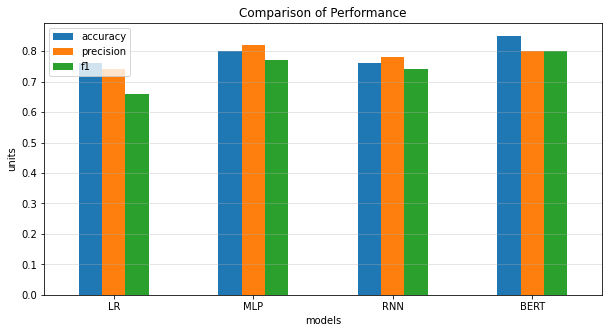

In [ ]:
df_performance.plot.bar(x='model', rot=0, figsize=(10,5))
plt.title('Comparison of Performance')
plt.xlabel('models')
plt.ylabel('units')
plt.grid(axis = 'y', alpha = 0.4)
plt.show()

#### Best Model: BERT